In [265]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import os
import scipy.io
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import pearsonr, zscore
from scipy.io import savemat
import random
from utils import daily_blocks, extract_all_licks, get_tone_response_df, block_stim_evoke_response, load_behavior_txt
from sklearn.decomposition import PCA
plt.rcParams['axes.facecolor'] = 'white'
outcome_list = ['Hit', 'Miss', 'FA', 'CR']
mouse_names = ['jl009', 'fz017', 'fz009', 'fz006']
data_paths = ["Z:/Jenni/jl009/behavimaging.mat",
             "W:/Jenni/fz017/behavimaging.mat",
             "Y:/Jenni/fz009/behavimaging.mat",
             "Y:/sarah/fz006/behavimaging.mat"]
disks = ['Z', 'W', 'Y', 'Y']

mouse_id = 0
mouse_name = mouse_names[mouse_id]
disk = disks[mouse_id]

data_path = "{}_behavimaging.mat".format(mouse_name)
mat = scipy.io.loadmat(data_path)
data = mat['behavimaging']
nBlocks = data.shape[-1]
nDays = data[0, -1]['day'][0][0]

valid_days = []
for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        valid_days.append(day)
cmap = plt.cm.get_cmap('viridis_r')
if mouse_name == 'jl009':
    valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    im_proportion = 0.3
if mouse_name == 'fz017':
    valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]
    im_proportion = 0.2
    
day_groups_all = [[[1,2,3], [5,6], [7,8,9], [15]], 
                 [[1,2,4,5], [6,7,8,9,10], [11, 12,14,15], [17,23], [24,25,26]],
                 [],
                 [[1,2,3,4,5], [6,9,10], [11,15]]]

In [236]:
def remove_false(inputx, inputy):
    inputy = np.array(inputy)
    inputx = np.array(inputx)
    valid_ind = np.where(inputy > 0)[0]
    return inputx[valid_ind], inputy[valid_ind]

def important_axons(stim_w, proportion=0.1):
    # thresh = 0.001
    # axons_contribution = np.mean(stim_weights[:, 45:], axis=1)
    # axons_contribution_prelick = np.mean(prelick_weights[:, :45], axis=1)
    # idx = np.where(axons_contribution > thresh)[0]
    # non_idx = np.where(axons_contribution <= thresh)[0]
    NA = stim_weights.shape[0]
    axons_contribution = np.mean(stim_weights[:, 45:], axis=1)
    axons_contribution_threshold = np.mean(axons_contribution) + np.std(axons_contribution)
    w_sort = np.argsort(axons_contribution)
    NNA = int(proportion*NA)
    idx = w_sort[-NNA:]
    non_idx = w_sort[:(NA-NNA)]
#     idx = np.where(axons_contribution > axons_contribution_threshold)
#     non_idx = np.where(axons_contribution <= axons_contribution_threshold)
    return idx, non_idx

def classifier(x, y, ratio=2/3):
    '''
    ratio: train:test
    '''
    accs = []
    weights = []
    # make sure each class has same number of samples
    ind1 = np.where(y==0)[0]
    ind2 = np.where(y==1)[0]
    valid_amount = min(len(ind2), len(ind1))
    if valid_amount < 10:
        print('no avalible binary labels for classifier')
        return False, False
    valid_ind1 = ind1[np.random.choice(np.arange(len(ind1)), valid_amount, replace=False)]
    valid_ind2 = ind2[np.random.choice(np.arange(len(ind2)), valid_amount, replace=False)]
    valid_ind = np.hstack([valid_ind1, valid_ind2])
    print('valid samples: {}'.format(len(valid_ind)))
    x = x[valid_ind]
    y = y[valid_ind]
    N = len(x) # number of samples
    F = x.shape[1] # number of features
    for seed in range(10):
        random.seed(seed)
        np.random.seed(seed)
        itrain = np.random.choice(np.arange(N), size=int(N*ratio), replace=False)
        itest = np.setxor1d(np.arange(N), itrain)
        ylabel = y[itrain]
        new_seed = 1000
        while (np.sum(ylabel[0] == ylabel) == len(ylabel)):
            new_seed +=1
            random.seed(seed+new_seed)
            np.random.seed(seed+new_seed)
            itrain = np.random.choice(np.arange(N), size=int(N*ratio), replace=False)
            itest = np.setxor1d(np.arange(N), itrain)
            ylabel = y[itrain]
            if new_seed >= 1050:
                print('no avalible binary labels for classifier')
                return False, False

        model = LogisticRegression(solver='liblinear', random_state=seed)
        model.fit(x[itrain], y[itrain])
        te_pred = model.predict(x[itest])
        acc = np.sum(te_pred == y[itest]) / len(itest)
        cur_weights = model.coef_
        accs.append(acc)
        weights.append(cur_weights)
    avg_acc = np.mean(accs)
    weights = np.mean(np.array(weights), axis=0)
    return avg_acc, weights

def behavior_performance(mouse_name, drive):
    beh_data_path = "{}:/Jenni/{}/behavior/justbehavior".format(drive, mouse_name)
    fnames = [_ for _ in os.listdir(beh_data_path) if _.endswith('txt')]

    from tkinter import Tcl
    fnames = Tcl().call('lsort', '-dict', fnames)
    nBlocks = len(fnames)
    pbRes = np.zeros((4, nBlocks))
    rlRes = np.zeros((4, nBlocks))
    nPB = np.zeros(nBlocks)
    days = np.zeros(nBlocks)
    for i in range(nBlocks):
        tmp = fnames[i].split('_')[-1]
        days[i] = int(tmp.split('v')[0])
        fpath = os.path.join(beh_data_path, fnames[i])
        bmat = load_behavior_txt(fpath)
        behavior = bmat[:, 12].reshape(-1).astype(int)
        outcome = bmat[:, 3].reshape(-1).astype(int)
        nPB[i] = np.sum(behavior==0)
        if nPB[i] > 0:
            pbIdx = np.where(behavior==0)
            pbOutcome = outcome[pbIdx]
            for j in range(4):
                pbRes[j, i] = np.sum(pbOutcome == j+1) / nPB[i]

        rlIdx = np.where(behavior==1)
        rlOutcome = outcome[rlIdx]
        for j in range(4):
            rlRes[j, i] = np.sum(rlOutcome == j+1) / (100 - nPB[i])
    days = days.astype('int')
    x = np.arange(nBlocks)
    ptrue = pbRes[0] + pbRes[3]
    rtrue = rlRes[0] + rlRes[3]
    return ptrue, rtrue, fnames

In [182]:
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
def smooth_line(inputx, inputy):
    xx = np.linspace(inputx.min(),inputx.max(), 1000)
    itp = interp1d(inputx,inputy, kind='linear')
    window_size, poly_order = 301, 2
    yy = savgol_filter(itp(xx), window_size, poly_order) # smooth
    return xx, yy

# load lick

In [7]:
block = data[0, 0]
raw_spks = block['imagingdata']
NA, NT = raw_spks.shape
spks = zscore(raw_spks, axis=1)
# spks = sigmoid(spks)
nan_flag = np.isnan(np.sum(spks, axis=1))
not_nan_ind = np.where(nan_flag==False)[0]
spks = spks[not_nan_ind]

behavior = block['behavdata']
istim = np.where(behavior[0] > 0)[0]
cues = behavior[0, istim]
outcomes = behavior[1, istim]
ifirstlicks = -np.ones(len(istim))
licks = behavior[3]

T = len(licks)
print(licks.shape, spks.shape)

(13540,) (175, 13540)


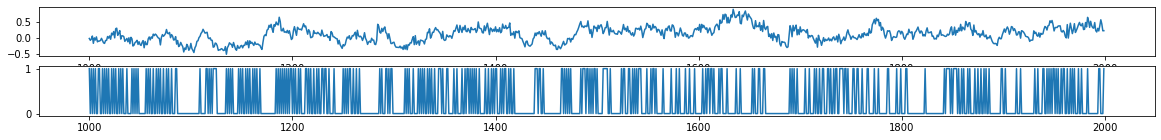

In [15]:
plt.figure(figsize=(20, 2))
x = np.arange(T)
xrange = np.arange(1000, 2000)
plt.subplot(211)
plt.plot(x[xrange], np.mean(spks, axis=0)[xrange])
plt.subplot(212)
plt.plot(x[xrange], licks[xrange])

In [19]:
window_size = 15
flick = np.convolve(licks, np.ones(window_size), mode='valid') # to Hz
spks = spks[:, int(window_size/2):(-int(window_size/2))]
print(flick.shape, spks.shape)

(13526,) (175, 13526)


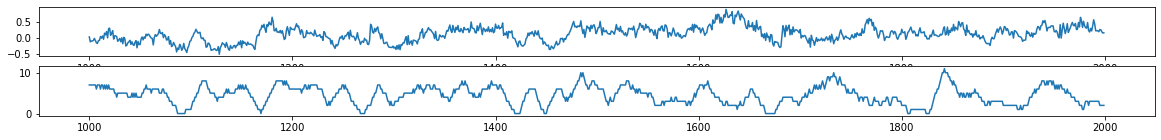

In [21]:
plt.figure(figsize=(20, 2))
x = np.arange(T)
xrange = np.arange(1000, 2000)
plt.subplot(211)
plt.plot(x[xrange], np.mean(spks, axis=0)[xrange])
plt.subplot(212)
plt.plot(x[xrange], flick[xrange])

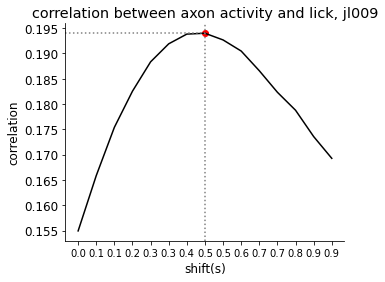

In [57]:
from scipy.stats import pearsonr
shift = 3
pvs = [pearsonr(flick, avg_spks)[0]]
for shift in range(1, 15):
    avg_spks = np.mean(spks, axis=0)
    shift_flick = flick[:(-shift)]
    shift_spks = avg_spks[shift:]
    pv = pearsonr(shift_flick, shift_spks)[0]
    pvs.append(pv)
    
plt.figure(figsize=(5,4))
plt.rcParams['font.size'] = 12
x = np.arange(15)
plt.plot(x, pvs, color='black')
ind = np.argmax(pvs)
plt.scatter(ind, pvs[ind], color='red')
plt.axvline(ind, ymax=pvs[ind]/max(pvs), color='gray', linestyle=':')
plt.axhline(pvs[ind], xmax=ind/max(x), color='gray', linestyle=':')
plt.xlabel('shift(s)')
plt.ylabel('correlation')
plt.xticks(x, labels=["{:.1f}".format(k*(1/15)) for k in x], fontsize=10)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('correlation between axon activity and lick, {}'.format(mouse_name))
plt.savefig('figure/correlation/axon_lick_corr_shift_{}'.format(mouse_name))
# activity is later than lick

In [73]:
# correlation of each axon with lick
print(spks.shape, flick.shape)
NA, T = spks.shape

from scipy.stats import zscore
zspks = zscore(spks, axis=1) 
zlicks = zscore(flick).reshape(T, 1) 
corrs = np.matmul(zspks, zlicks).squeeze() / T
print(corrs.shape)

(175, 13526) (13526,)
(175,)


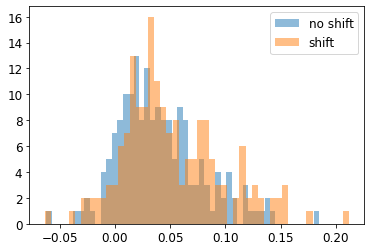

In [75]:
shift = 7
shift_flick = flick[:(-shift)]
shift_spks = spks[:, shift:]
NA, T = shift_spks.shape
zspks = zscore(shift_spks, axis=1) 
zlicks = zscore(shift_flick).reshape(T, 1) 
shift_corrs = np.matmul(zspks, zlicks).squeeze() / T
plt.hist(corrs, bins=50, alpha=0.5, label='no shift')
plt.hist(shift_corrs, bins=50, alpha=0.5, label='shift')
plt.legend()
plt.show()

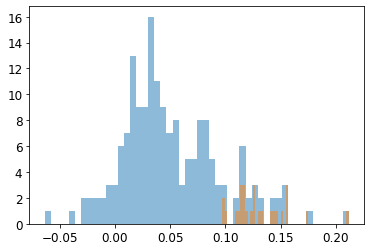

In [72]:
thresh = np.mean(corrs) + np.std(corrs)
hcorr_ind = np.where(corrs > thresh)[0]
plt.hist(corrs, bins=50, alpha=0.5)
plt.hist(corrs[hcorr_ind], bins=50, alpha=0.5)
plt.show()

## corr distribution in each mouse 
based on the distribution, set the motor driven threshold as 0.1 (without shift)

In [249]:
print('start')
for mouse_id in [1]:
    mouse_name = mouse_names[mouse_id]
    disk = disks[mouse_id]

    data_path = "{}_behavimaging.mat".format(mouse_name)
    mat = scipy.io.loadmat(data_path)
    data = mat['behavimaging']
    blocks = []
    days = []
    if mouse_name == 'jl009':
        valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    if mouse_name == 'fz017':
        valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]
    for i, day in enumerate(valid_days):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            for iblock in iblocks:
                blocks.append(iblock)
                days.append(day)

    all_pv = np.zeros((15, len(blocks)))
    for i, iblock in enumerate(blocks):
        block = data[0, iblock]
        raw_spks = block['imagingdata']
        NA, NT = raw_spks.shape
        spks = zscore(raw_spks, axis=1)
        # spks = sigmoid(spks)
        nan_flag = np.isnan(np.sum(spks, axis=1))
        not_nan_ind = np.where(nan_flag==False)[0]
        spks = spks[not_nan_ind]

        behavior = block['behavdata']
        istim = np.where(behavior[0] > 0)[0]
        cues = behavior[0, istim]
        outcomes = behavior[1, istim]
        ifirstlicks = -np.ones(len(istim))
        licks = behavior[3]

        T = len(licks)

        window_size = 15
        flick = np.convolve(licks, np.ones(window_size), mode='valid') # to Hz
        if np.sum(flick) != 0:
            spks = spks[:, int(window_size/2):(-int(window_size/2))]
            avg_spks = np.mean(spks, axis=0)
            all_pv[0, i] = pearsonr(flick, avg_spks)[0]

            for shift in range(1, 15):
                avg_spks = np.mean(spks, axis=0)
                shift_flick = flick[:(-shift)]
                shift_spks = avg_spks[shift:]
                all_pv[shift, i] = pearsonr(shift_flick, shift_spks)[0]
            
    plt.figure(figsize=(5,4))
    plt.rcParams['font.size'] = 11
    x = np.arange(15)
    plt.xlabel('shift(s)')
    plt.ylabel('correlation')
    ymean = np.mean(all_pv, axis=1)
    plt.plot(x, ymean, color='black')
    ci = 1.96 * np.std(all_pv, axis=1)/np.sqrt(len(blocks))
    plt.xticks(x, labels=["{:.1f}".format(k*(1/15)) for k in x], fontsize=10)
    plt.fill_between(x, (ymean-ci), (ymean+ci), color='b', alpha=.1)
    ind = np.argmax(ymean)
    plt.scatter(ind, ymean[ind], color='red')
    plt.axvline(ind, ymax=ymean[ind]/0.38, color='gray', linestyle=':')
    plt.axhline(ymean[ind], xmax=ind/max(x), color='gray', linestyle=':')
    plt.ylim([0.1, 0.5])
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title('correlation between axon activity and lick, {}'.format(mouse_name))
    plt.savefig('figure/correlation/axon_lick_corr_shift_{}'.format(mouse_name))
    plt.close()

start


6


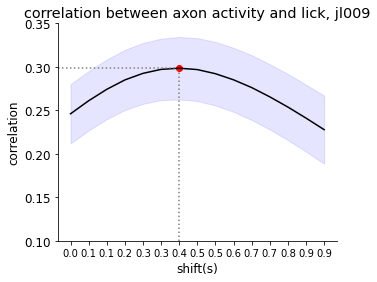

In [103]:
plt.figure(figsize=(5,4))
plt.rcParams['font.size'] = 12
x = np.arange(15)
plt.xlabel('shift(s)')
plt.ylabel('correlation')
ymean = np.mean(all_pv, axis=1)
plt.plot(x, ymean, color='black')
ci = 1.96 * np.std(all_pv, axis=1)/np.sqrt(len(blocks))
plt.xticks(x, labels=["{:.1f}".format(k*(1/15)) for k in x], fontsize=10)
plt.fill_between(x, (ymean-ci), (ymean+ci), color='b', alpha=.1)
ind = np.argmax(ymean)
plt.scatter(ind, ymean[ind], color='red')
plt.axvline(ind, ymax=ymean[ind]/0.38, color='gray', linestyle=':')
plt.axhline(ymean[ind], xmax=ind/max(x), color='gray', linestyle=':')
print(ind)
plt.ylim([0.1, 0.35])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('correlation between axon activity and lick, {}'.format(mouse_name))
plt.savefig('figure/correlation/axon_lick_corr_shift_{}'.format(mouse_name))

In [117]:
print('start')
for mouse_id in range(4):
    mouse_name = mouse_names[mouse_id]
    disk = disks[mouse_id]

    data_path = "{}_behavimaging.mat".format(mouse_name)
    mat = scipy.io.loadmat(data_path)
    data = mat['behavimaging']
    blocks = []
    days = []
    if mouse_name == 'jl009':
        valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    if mouse_name == 'fz017':
        valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]
    for i, day in enumerate(valid_days):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            for iblock in iblocks:
                blocks.append(iblock)
                days.append(day)

    all_corrs = []
    all_shift_corrs = []
    for i, iblock in enumerate(blocks):
        block = data[0, iblock]
        raw_spks = block['imagingdata']
        NA, NT = raw_spks.shape
        spks = zscore(raw_spks, axis=1)
        # spks = sigmoid(spks)
        nan_flag = np.isnan(np.sum(spks, axis=1))
        not_nan_ind = np.where(nan_flag==False)[0]
        spks = spks[not_nan_ind]

        behavior = block['behavdata']
        istim = np.where(behavior[0] > 0)[0]
        cues = behavior[0, istim]
        outcomes = behavior[1, istim]
        ifirstlicks = -np.ones(len(istim))
        licks = behavior[3]
        # filter lick
        window_size = 15
        flick = np.convolve(licks, np.ones(window_size), mode='valid') # to Hz
        spks = spks[:, int(window_size/2):(-int(window_size/2))]

        # correlation of each axon with lick
        NA, T = spks.shape
        zspks = zscore(spks, axis=1) 
        zlicks = zscore(flick).reshape(T, 1) 
        corrs = np.matmul(zspks, zlicks).squeeze() / T

        shift = 6
        shift_flick = flick[:(-shift)]
        shift_spks = spks[:, shift:]
        NA, T = shift_spks.shape
        zspks = zscore(shift_spks, axis=1) 
        zlicks = zscore(shift_flick).reshape(T, 1)   
        shift_corrs = np.matmul(zspks, zlicks).squeeze() / T

        all_corrs.append(corrs)
        all_shift_corrs.append(shift_corrs)

    all_corrs_flat = np.hstack(all_corrs)
    all_shift_corrs_flat = np.hstack(all_shift_corrs)

    plt.hist(all_corrs_flat, bins=50, alpha=0.5, label='no shift')
    plt.hist(all_shift_corrs_flat, bins=50, alpha=0.5, label='shift')

    thresh = np.mean(all_shift_corrs_flat) + np.std(all_shift_corrs_flat)
    hcorr_ind = np.where(all_shift_corrs_flat > thresh)[0]
    plt.hist(all_shift_corrs_flat[hcorr_ind], bins=50, alpha=0.5, label='>95% CI, {:.3f}'.format(thresh))
    plt.legend()

    plt.title('correlation distribution, {}'.format(mouse_name))
    plt.savefig('figure/correlation/correlation_distribution_{}'.format(mouse_name))
    plt.close()
print('finish')

start
finish


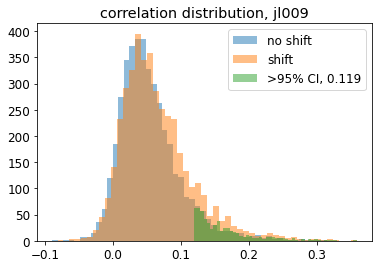

In [115]:
plt.hist(all_corrs_flat, bins=50, alpha=0.5, label='no shift')
plt.hist(all_shift_corrs_flat, bins=50, alpha=0.5, label='shift')

thresh = np.mean(all_shift_corrs_flat) + np.std(all_shift_corrs_flat)
hcorr_ind = np.where(all_shift_corrs_flat > thresh)[0]
plt.hist(all_shift_corrs_flat[hcorr_ind], bins=50, alpha=0.5, label='>95% CI, {:.3f}'.format(thresh))
plt.legend()

plt.title('correlation distribution, {}'.format(mouse_name))
plt.savefig('figure/correlation/correlation_distribution_{}'.format(mouse_name))
plt.show()

# axon activity

In [163]:
rthresh = 0.1
pre_window = 45
window_size = 15 # filter of lick
day = 1
for mouse_id in range(4):
    mouse_name = mouse_names[mouse_id]
    disk = disks[mouse_id]

    data_path = "{}_behavimaging.mat".format(mouse_name)
    mat = scipy.io.loadmat(data_path)
    data = mat['behavimaging']
    blocks = []
    valid_days = []
    for day in range(1, nDays+1):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            valid_days.append(day)

    if mouse_name == 'jl009':
        valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    if mouse_name == 'fz017':
        valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]

    for i, day in enumerate(valid_days):
        print('-------------------day {}---------------------'.format(day))
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            daily_cues = []
            daily_outcomes = []
            daily_responses = []
            daily_firstlicks = []
            daily_alllicks = []
            daily_corrs = []
            valid = True
            for j in iblocks:
                block = data[0, j]
                # normalize doesn't have much effect on the result, so set it to False
                cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
                if len(daily_responses) > 0:
                    if daily_responses[0].shape != stim_resp.shape:
                        valid = False
                if valid == True:
                    raw_spks = block['imagingdata']
                    spks = zscore(raw_spks, axis=1)
                    # spks = sigmoid(spks)
                    nan_flag = np.isnan(np.sum(spks, axis=1))
                    not_nan_ind = np.where(nan_flag==False)[0]
                    spks = spks[not_nan_ind]

                    behavior = block['behavdata']
                    licks = behavior[3]
                    flick = np.convolve(licks, np.ones(window_size), mode='valid') # to Hz
                    spks = spks[:, int(window_size/2):(-int(window_size/2))]
                    if np.mean(flick) > 0:
                        # correlation of each axon with lick
                        NA, T = spks.shape
                        zspks = zscore(spks, axis=1) 
                        zlicks = zscore(flick).reshape(T, 1) 
                        corrs = np.matmul(zspks, zlicks).reshape(1, NA) / T
                        daily_corrs.append(corrs)
                        daily_cues.append(cues)
                        daily_outcomes.append(outcomes)
                        daily_responses.append(stim_resp)
                        daily_firstlicks.append(firstlicks)
                        daily_alllicks.append(alllicks)

            daily_cues = np.hstack(daily_cues)
            daily_outcomes = np.hstack(daily_outcomes)
            daily_responses = np.vstack(daily_responses)
            daily_alllicks = np.vstack(daily_alllicks)
            daily_corrs = np.vstack(corrs)

            nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
            inotnan = np.where(nanflag==0)
            daily_responses = daily_responses[inotnan]
            daily_cues = daily_cues[inotnan]
            daily_outcomes = daily_outcomes[inotnan]
            daily_alllicks = daily_alllicks[inotnan]
            NT, NA, NF = daily_responses.shape
            stim = np.ones(daily_cues.shape)
            stim[np.where(daily_cues==2)] = 0 
            stim[np.where(daily_cues==4)] = 0
            stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

            corrs = np.mean(daily_corrs, axis=0)
            mdriven_ind = np.where(corrs > rthresh)[0]
            isort = np.argsort(corrs[mdriven_ind])
            mdriven_ind = mdriven_ind[isort]
            nondriven_ind = np.where(corrs <= rthresh)[0]
            isort = np.argsort(corrs[nondriven_ind])
            nondriven_ind = nondriven_ind[isort]
            isort = np.hstack([mdriven_ind, nondriven_ind])
       
            plt.figure(figsize=(20,4))
            for outcome_index in range(1,5):
                all_resp = np.zeros((NA, 90*2+5))
                ioutcome = np.where(daily_outcomes == outcome_index)[0]
                oresp = daily_responses[ioutcome]

                lick = daily_alllicks[ioutcome] 
                n_prelicks = np.sum(lick[:, 15:30], axis=1)
                lick_idx = np.where(n_prelicks != 0)[0] # with prelick
                resp = oresp[lick_idx]
                resp = resp.mean(axis=0) # average response of each axon in one day for a outcome. -> (NN, 75)
                all_resp[:, :90] = resp[isort]

                nolick_idx = np.where(n_prelicks == 0)[0] # without prelick
                resp = oresp[nolick_idx]
                resp = resp.mean(axis=0) # average response of each axon in one day for a outcome. -> (NN, 75)
                all_resp[:, (90+5):] = resp[isort]

                plt.subplot(1,4,outcome_index)
                plt.imshow(all_resp, cmap='jet', vmin=-0.1, vmax=0.4)
                plt.ylabel('axons')
                plt.title('{}, lick, no lick'.format(outcome_list[outcome_index-1]))
                plt.colorbar()
            plt.suptitle('day {}, axon activity, sort by correlation with lick, {}'.format(day, mouse_name))
            plt.savefig('figure/correlation/axon_raster_sort-by-corr_day{}_{}'.format(day, mouse_name))
            plt.close()
print('finish')

-------------------day 1---------------------
-------------------day 2---------------------
-------------------day 3---------------------
-------------------day 5---------------------


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_30024/65738649.py:104: RuntimeWarning: Mean of empty slice.
  resp = resp.mean(axis=0) # average response of each axon in one day for a outcome. -> (NN, 75)


-------------------day 6---------------------
-------------------day 7---------------------
-------------------day 8---------------------
-------------------day 9---------------------
-------------------day 15---------------------
-------------------day 1---------------------
-------------------day 2---------------------
-------------------day 4---------------------
-------------------day 5---------------------
-------------------day 6---------------------
-------------------day 7---------------------
-------------------day 8---------------------
-------------------day 9---------------------
-------------------day 10---------------------
-------------------day 11---------------------
-------------------day 12---------------------
-------------------day 14---------------------
-------------------day 15---------------------
-------------------day 17---------------------
-------------------day 23---------------------
-------------------day 24---------------------
-------------------day 25

## average response

In [252]:
mouse_id = 0
for mouse_id in range(4):
    mouse_name = mouse_names[mouse_id]
    disk = disks[mouse_id]

    data_path = "{}_behavimaging.mat".format(mouse_name)
    mat = scipy.io.loadmat(data_path)
    data = mat['behavimaging']
    blocks = []
    valid_days = []
    for day in range(1, nDays+1):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            valid_days.append(day)

    if mouse_name == 'jl009':
        valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    if mouse_name == 'fz017':
        valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]

    m_all_oresp = np.zeros((4, len(valid_days), 90))
    n_all_oresp = np.zeros((4, len(valid_days), 90))
    for i, day in enumerate(valid_days):
        print('-------------------day {}---------------------'.format(day))
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            daily_cues = []
            daily_outcomes = []
            daily_responses = []
            daily_firstlicks = []
            daily_alllicks = []
            daily_corrs = []
            valid = True
            for j in iblocks:
                block = data[0, j]
                # normalize doesn't have much effect on the result, so set it to False
                cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
                if len(daily_responses) > 0:
                    if daily_responses[0].shape != stim_resp.shape:
                        valid = False
                if valid == True:
                    raw_spks = block['imagingdata']
                    spks = zscore(raw_spks, axis=1)
                    # spks = sigmoid(spks)
                    nan_flag = np.isnan(np.sum(spks, axis=1))
                    not_nan_ind = np.where(nan_flag==False)[0]
                    spks = spks[not_nan_ind]

                    behavior = block['behavdata']
                    licks = behavior[3]
                    flick = np.convolve(licks, np.ones(window_size), mode='valid') # to Hz
                    spks = spks[:, int(window_size/2):(-int(window_size/2))]
                    if np.mean(flick) > 0:
                        # correlation of each axon with lick
                        NA, T = spks.shape
                        zspks = zscore(spks, axis=1) 
                        zlicks = zscore(flick).reshape(T, 1) 
                        corrs = np.matmul(zspks, zlicks).reshape(1, NA) / T
                        daily_corrs.append(corrs)
                        daily_cues.append(cues)
                        daily_outcomes.append(outcomes)
                        daily_responses.append(stim_resp)
                        daily_firstlicks.append(firstlicks)
                        daily_alllicks.append(alllicks)

            daily_cues = np.hstack(daily_cues)
            daily_outcomes = np.hstack(daily_outcomes)
            daily_responses = np.vstack(daily_responses)
            daily_alllicks = np.vstack(daily_alllicks)
            daily_corrs = np.vstack(corrs)

            nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
            inotnan = np.where(nanflag==0)
            daily_responses = daily_responses[inotnan]
            daily_cues = daily_cues[inotnan]
            daily_outcomes = daily_outcomes[inotnan]
            daily_alllicks = daily_alllicks[inotnan]
            NT, NA, NF = daily_responses.shape
            stim = np.ones(daily_cues.shape)
            stim[np.where(daily_cues==2)] = 0 
            stim[np.where(daily_cues==4)] = 0
            stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

            corrs = np.mean(daily_corrs, axis=0)
            mdriven_ind = np.where(corrs > rthresh)[0]
            isort = np.argsort(corrs[mdriven_ind])
            mdriven_ind = mdriven_ind[isort]
            nondriven_ind = np.where(corrs <= rthresh)[0]
            isort = np.argsort(corrs[nondriven_ind])
            nondriven_ind = nondriven_ind[isort]
            isort = np.hstack([mdriven_ind, nondriven_ind])
            if len(mdriven_ind) > 10:
                for outcome_index in range(1,5):
                    all_resp = np.zeros((NA, 90*2+5))
                    ioutcome = np.where(daily_outcomes == outcome_index)[0]
                    oresp = daily_responses[ioutcome]
                    oresp = np.mean(oresp, axis=0)
                    # x = np.arange(NF)
                    # xx, yy = smooth_line(x, moresp)
                    n_all_oresp[outcome_index-1, i] = np.mean(oresp, axis=0)
                    m_all_oresp[outcome_index-1, i] = np.mean(oresp[mdriven_ind], axis=0)
                # plt.plot(xx, yy, label='day {}'.format(day), color=cmap(i/len(valid_days)))
    # plt.legend()

    cmap = plt.cm.get_cmap('viridis_r')
    plt.rcParams['legend.fontsize'] = 10
    plt.figure(figsize=(20,4))
    for outcome_index in range(1,5):
        plt.subplot(1, 4, outcome_index)
        for i in range(len(valid_days)):
            oresp = m_all_oresp[outcome_index-1, i] 
            # oresp = oresp - np.mean(oresp[35:45])
            x = np.arange(NF)
            xx, yy = smooth_line(x, oresp)
            plt.plot(xx, yy, label='day {}'.format(day), color=cmap(i/len(valid_days)))
        plt.title(outcome_list[outcome_index-1])
        plt.ylim([-0.4, 0.5])
        plt.legend()
    plt.suptitle('response in motor driven axons, {}'.format(mouse_name))
    plt.savefig('figure/mdriven_avg_spk_{}'.format(mouse_name))
    plt.close()

    mc_y = []
    hf_y = []
    plt.figure(figsize=(6,3))
    days = []
    for i in range(len(valid_days)):
        if np.mean(m_all_oresp[1, i]) != 0:
            days.append(valid_days[i])
            diffresp = np.mean(m_all_oresp[1, i, 45:60]) - np.mean(m_all_oresp[3, i, 45:60])
            mc_y.append(diffresp)
            diffresp = np.mean(m_all_oresp[0, i, 45:60]) - np.mean(m_all_oresp[2, i, 45:60])
            hf_y.append(diffresp)
    x = np.arange(len(days))  
    plt.plot(x, mc_y, label='Miss and CR')
    plt.plot(x, hf_y, label='Hit and FA')
    plt.legend()
    plt.xticks(x, labels=days)
    plt.title('response difference between Miss and CR, {}'.format(mouse_name))
    plt.savefig('figure/difference_between_MissCR_spk_{}'.format(mouse_name), dpi=100)
    plt.close()

-------------------day 1---------------------
-------------------day 2---------------------
-------------------day 3---------------------
-------------------day 5---------------------
-------------------day 6---------------------
-------------------day 7---------------------
-------------------day 8---------------------
-------------------day 9---------------------
-------------------day 15---------------------
-------------------day 1---------------------
-------------------day 2---------------------
-------------------day 4---------------------
-------------------day 5---------------------
-------------------day 6---------------------
-------------------day 7---------------------
-------------------day 8---------------------
-------------------day 9---------------------
-------------------day 10---------------------
-------------------day 11---------------------
-------------------day 12---------------------
-------------------day 14---------------------
-------------------day 15----

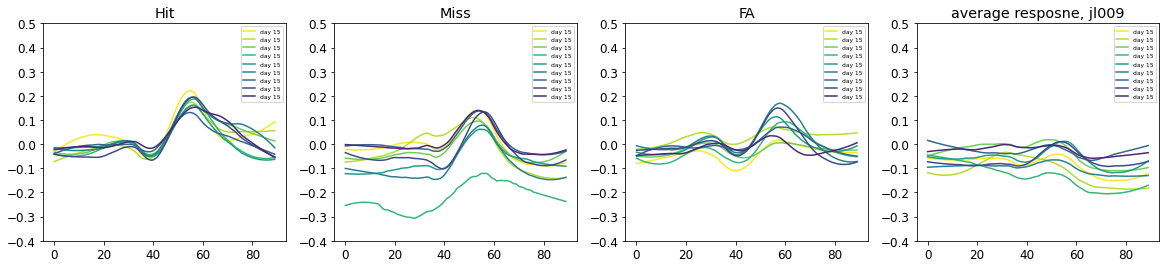

In [210]:
cmap = plt.cm.get_cmap('viridis_r')
plt.rcParams['legend.fontsize'] = 6
plt.figure(figsize=(20,4))
for outcome_index in range(1,5):
    plt.subplot(1, 4, outcome_index)
    for i in range(len(valid_days)):
        oresp = all_oresp[outcome_index-1, i] 
        # oresp = oresp - np.mean(oresp[35:45])
        x = np.arange(NF)
        xx, yy = smooth_line(x, oresp)
        plt.plot(xx, yy, label='day {}'.format(day), color=cmap(i/len(valid_days)))
    plt.title(outcome_list[outcome_index-1])
    plt.ylim([-0.4, 0.5])
    plt.legend()
plt.title('average resposne, {}'.format(mouse_name))
plt.savefig('figure/average_response_all_{}'.format(mouse_name))
plt.show()

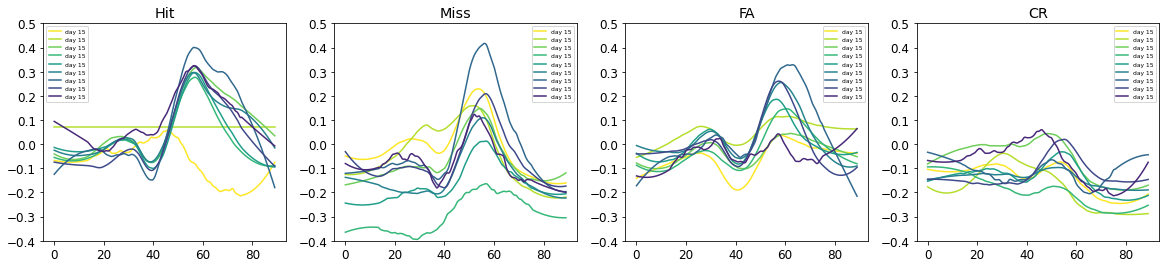

In [207]:
cmap = plt.cm.get_cmap('viridis_r')
plt.rcParams['legend.fontsize'] = 6
plt.figure(figsize=(20,4))
for outcome_index in range(1,5):
    plt.subplot(1, 4, outcome_index)
    for i in range(len(valid_days)):
        oresp = all_oresp[outcome_index-1, i] 
        # oresp = oresp - np.mean(oresp[35:45])
        x = np.arange(NF)
        xx, yy = smooth_line(x, oresp)
        plt.plot(xx, yy, label='day {}'.format(day), color=cmap(i/len(valid_days)))
    plt.title(outcome_list[outcome_index-1])
    plt.ylim([-0.4, 0.5])
    plt.legend()
plt.show()

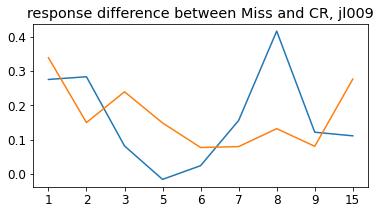

In [221]:
mc_y = []
hf_y = []
plt.figure(figsize=(6,3))
for i in range(len(valid_days)):
    diffresp = np.mean(m_all_oresp[1, i, 45:60]) - np.mean(m_all_oresp[3, i, 45:60])
    mc_y.append(diffresp)
    diffresp = np.mean(m_all_oresp[0, i, 45:60]) - np.mean(m_all_oresp[2, i, 45:60])
    hf_y.append(diffresp)
x = np.arange(len(valid_days))  
plt.plot(x, mc_y, label='Miss and CR')
plt.plot(x, hf_y, label='Hit and FA')
plt.xticks(x, labels=valid_days)
plt.title('response difference between Miss and CR, {}'.format(mouse_name))
plt.savefig('figure/difference_between_MissCR_spk_{}'.format(mouse_name))

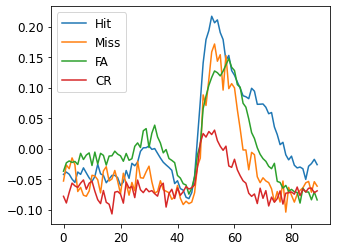

In [176]:
plt.figure(figsize=(5,4))
for outcome_index in range(1,5):
    all_resp = np.zeros((NA, 90*2+5))
    ioutcome = np.where(daily_outcomes == outcome_index)[0]
    oresp = daily_responses[ioutcome]
    oresp = np.mean(oresp, axis=0)
    x = np.arange(NF)
    plt.plot(x, np.mean(oresp[nondriven_ind], axis=0), label='{}'.format(outcome_list[outcome_index-1]))
plt.legend()

# decoding from all

In [282]:
mouse_id = 0
for mouse_id in range(4):
    # for mouse_id in range(4):
    mouse_name = mouse_names[mouse_id]
    disk = disks[mouse_id]

    data_path = "{}_behavimaging.mat".format(mouse_name)
    mat = scipy.io.loadmat(data_path)
    data = mat['behavimaging']
    blocks = []
    valid_days = []
    for day in range(1, nDays+1):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            valid_days.append(day)

    if mouse_name == 'jl009':
        valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    if mouse_name == 'fz017':
        valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]

    all_acc = np.zeros((3, len(valid_days))) # prediction acc with all activities in the time window
    pb_acc = np.zeros((3, len(valid_days))) 
    pre_window=45
    
    stim_weights = []
    prelick_weights = []
    postlick_weights = []
    for i, day in enumerate(valid_days):
        print('-------------------day {}---------------------'.format(day))
        print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            daily_cues = []
            daily_outcomes = []
            daily_responses = []
            daily_firstlicks = []
            daily_alllicks = []
            valid = True
            for j in iblocks:
                block = data[0, j]
                # normalize doesn't have much effect on the result, so set it to False
                cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
                if len(daily_responses) > 0:
                    if daily_responses[0].shape != stim_resp.shape:
                        valid = False
                if valid == True:
                    daily_cues.append(cues)
                    daily_outcomes.append(outcomes)
                    daily_responses.append(stim_resp)
                    daily_firstlicks.append(firstlicks)
                    daily_alllicks.append(alllicks)

            daily_cues = np.hstack(daily_cues)
            daily_outcomes = np.hstack(daily_outcomes)
            daily_responses = np.vstack(daily_responses)
            daily_alllicks = np.vstack(daily_alllicks)

        nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
        inotnan = np.where(nanflag==0)
        daily_responses = daily_responses[inotnan]
        daily_cues = daily_cues[inotnan]
        daily_outcomes = daily_outcomes[inotnan]
        daily_alllicks = daily_alllicks[inotnan]
        NT, NA, NF = daily_responses.shape


        NT = len(daily_cues) # number of trials
        stim = np.ones(daily_cues.shape)
        stim[np.where(daily_cues==2)] = 0 
        stim[np.where(daily_cues==4)] = 0
        stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial
        
        spks = daily_responses[:, :, pre_window:]
        spks = spks.reshape(spks.shape[0], -1)
        acc, weights = classifier(spks, stim)
        weights = weights.reshape((NA, int(NF/2)))
        print('accuracy predicting stimulus identity on test set: ', acc)
        all_acc[0, i] = acc
        stim_weights.append(weights)
        
        spks = daily_responses.reshape(daily_responses.shape[0], -1)
        postlick = np.ones(daily_outcomes.shape)
        postlick[np.where(daily_outcomes==2)] = 0 
        postlick[np.where(daily_outcomes==4)] = 0
        postlick = np.multiply((postlick == 1), 1)  # lick: 1, nolick: 0
        if (np.mean(postlick) == 0) or (np.mean(postlick) == 1):
            acc, weights = 0.5, False
        else:
            acc, weights = classifier(spks, postlick)
            weights = weights.reshape((NA, NF))
        all_acc[1, i] = acc
        print('accuracy predicting postlick on test set: ', acc)
        postlick_weights.append(weights)

        prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
        prelick = np.multiply((prelick == 1), 1)
        if (np.mean(prelick) == 0) or (np.mean(prelick) == 1):
            acc, weights = 0.5, False
        else:
            acc, weights = classifier(spks, prelick)
            weights = weights.reshape((NA, NF))
        all_acc[2, i] = acc
        print('accuracy predicting prelick on test set: ', acc)
        prelick_weights.append(weights)
        
    # plot weight
    cmap = plt.cm.get_cmap('viridis_r')
    plt.rcParams['font.size'] = 12
    plt.rcParams['legend.fontsize'] = 8
    plt.figure(figsize=(6, 4))
    day_groups = day_groups_all[mouse_id]
    for i, days in enumerate(day_groups):
        wsum = 0
        for d in days:
            idx = np.where(np.array(valid_days) == d)[0][0]
            weight = stim_weights[idx]
            wsum += np.mean(weight, axis=0)
        wavg = wsum/len(days)
        # wavg = wavg - np.mean(wavg[:45])
        xx, yy = smooth_line(np.arange(len(wavg)), wavg)
        plt.plot(xx, yy, label='period {}'.format(i), color=cmap(i/len(day_groups)))
    plt.legend()
    plt.title('temporal contribution to stimulus classification, {}'.format(mouse_name))
    plt.xlabel('frame')
    plt.ylabel('avearge weight')
    plt.savefig('figure/decode_activity/weight_decoding_stim_fromspk_smooth_{}'.format(mouse_name))
    plt.close()
    
    plt.figure(figsize=(8, 4))
    for i, days in enumerate(day_groups):
        wsum = 0
        for d in days:
            idx = np.where(np.array(valid_days) == d)[0][0]
            weight = prelick_weights[idx]
            wsum += np.mean(weight, axis=0)
        wavg = wsum/len(days)
        # wavg = wavg - np.mean(wavg[:45])
        xx, yy = smooth_line(np.arange(len(wavg)), wavg)
        plt.plot(xx, yy, label='period {}'.format(i), color=cmap(i/len(day_groups)))
        plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
    plt.legend()
    plt.title('temporal contribution to prelick classification, {}'.format(mouse_name))
    plt.xlabel('frame')
    plt.ylabel('avearge weight')
    plt.savefig('figure/decode_activity/weight_decoding_prelick_fromspk_smooth_{}'.format(mouse_name))
    plt.close()

    plt.figure(figsize=(8, 4))
    for i, days in enumerate(day_groups):
        wsum = 0
        for d in days:
            idx = np.where(np.array(valid_days) == d)[0][0]
            weight = postlick_weights[idx]
            wsum += np.mean(weight, axis=0)
        wavg = wsum/len(days)
        # wavg = wavg - np.mean(wavg[:45])
        xx, yy = smooth_line(np.arange(len(wavg)), wavg)
        plt.plot(xx, yy, label='period {}'.format(i), color=cmap(i/len(day_groups)))
        plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
    plt.legend()
    plt.title('temporal contribution to postlick classification, {}'.format(mouse_name))
    plt.xlabel('frame')
    plt.ylabel('avearge weight')
    plt.savefig('figure/decode_activity/weight_decoding_postlick_fromspk_smooth_{}'.format(mouse_name))
    plt.close()
    
    cmap = plt.cm.get_cmap('viridis_r')
    plt.rcParams['font.size'] = 12
    plt.rcParams['legend.fontsize'] = 8
    plt.figure(figsize=(6, 4))
    day_groups = day_groups_all[mouse_id]
    for i, days in enumerate(day_groups):
        wsum = 0
        for d in days:
            idx = np.where(np.array(valid_days) == d)[0][0]
            weight = stim_weights[idx]
            wsum += np.mean(weight, axis=0)
        wavg = wsum/len(days)
        # wavg = wavg - np.mean(wavg[:45])
        plt.plot(np.arange(len(wavg)), wavg, label='period {}'.format(i), color=cmap(i/len(day_groups)))
    plt.legend()
    plt.title('temporal contribution to stimulus classification, {}'.format(mouse_name))
    plt.xlabel('frame')
    plt.ylabel('avearge weight')
    plt.savefig('figure/decode_activity/weight_decoding_stim_fromspk_raw_{}'.format(mouse_name))
    plt.close()
    
    plt.figure(figsize=(8, 4))
    for i, days in enumerate(day_groups):
        wsum = 0
        for d in days:
            idx = np.where(np.array(valid_days) == d)[0][0]
            weight = prelick_weights[idx]
            wsum += np.mean(weight, axis=0)
        wavg = wsum/len(days)
        # wavg = wavg - np.mean(wavg[:45])
        plt.plot(np.arange(len(wavg)), wavg, label='period {}'.format(i), color=cmap(i/len(day_groups)))
        plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
    plt.legend()
    plt.title('temporal contribution to prelick classification, {}'.format(mouse_name))
    plt.xlabel('frame')
    plt.ylabel('avearge weight')
    plt.savefig('figure/decode_activity/weight_decoding_prelick_fromspk_raw_{}'.format(mouse_name))
    plt.close()

    plt.figure(figsize=(8, 4))
    for i, days in enumerate(day_groups):
        wsum = 0
        for d in days:
            idx = np.where(np.array(valid_days) == d)[0][0]
            weight = postlick_weights[idx]
            wsum += np.mean(weight, axis=0)
        wavg = wsum/len(days)
        # wavg = wavg - np.mean(wavg[:45])
        plt.plot(np.arange(len(wavg)), wavg, label='period {}'.format(i), color=cmap(i/len(day_groups)))
        plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
    plt.legend()
    plt.title('temporal contribution to postlick classification, {}'.format(mouse_name))
    plt.xlabel('frame')
    plt.ylabel('avearge weight')
    plt.savefig('figure/decode_activity/weight_decoding_postlick_fromspk_raw_{}'.format(mouse_name))
    plt.close()


    beh_data_path = "{}:/Jenni/{}/behavior/justbehavior".format(disks[mouse_id], mouse_name)
    if mouse_name == 'fz006':
        beh_data_path = 'Y:/sarah/fz006/behavior/justbehavior'
    fnames = [_ for _ in os.listdir(beh_data_path) if _.endswith('txt')]

    from tkinter import Tcl
    fnames = Tcl().call('lsort', '-dict', fnames)

    nBlocks = len(fnames)
    pbRes = np.zeros((4, nBlocks))
    rlRes = np.zeros((4, nBlocks))
    nPB = np.zeros(nBlocks)
    days = np.zeros(nBlocks)
    for i in range(nBlocks):
        tmp = fnames[i].split('_')[-1]
        days[i] = int(tmp.split('v')[0])
        fpath = os.path.join(beh_data_path, fnames[i])
        bmat = load_behavior_txt(fpath)
        behavior = bmat[:, 12].reshape(-1).astype(int)
        outcome = bmat[:, 3].reshape(-1).astype(int)
        nPB[i] = np.sum(behavior==0)
        if nPB[i] > 0:
            pbIdx = np.where(behavior==0)
            pbOutcome = outcome[pbIdx]
            for j in range(4):
                pbRes[j, i] = np.sum(pbOutcome == j+1) / nPB[i]

        rlIdx = np.where(behavior==1)
        rlOutcome = outcome[rlIdx]
        for j in range(4):
            rlRes[j, i] = np.sum(rlOutcome == j+1) / (100 - nPB[i])
    days = days.astype('int')

    ptrue = pbRes[0] + pbRes[3]
    rtrue = rlRes[0] + rlRes[3]

    daymax = days.max()
    dptrue = np.zeros(daymax)
    drtrue = np.zeros(daymax)
    for d in range(daymax):
        dind = np.where(days==(d+1))
        dnPB = nPB[dind]
        pbind = np.where(dnPB == 20)[0]
        # if has probe trial in a day
        if pbind.shape[0] > 0:
            tmp = ptrue[dind]
            dptrue[d] = np.average(tmp[pbind], weights=dnPB[pbind])
        weights = 100 - dnPB
        drtrue[d] = np.average(rtrue[dind], weights=weights)

    colors = np.array(["green", "blue"])
    x = np.arange(1, daymax+1)
    plt.figure(figsize=(10, 5))
    plt.rcParams['font.size'] = 15
    plt.rcParams['legend.fontsize'] = 12
    dp_nonzero = np.where(dptrue>0)
    dr_nonzero = np.where(drtrue>0)
    plt.plot(x[dp_nonzero], dptrue[dp_nonzero], label='probe', color='red', linestyle=':')
    plt.plot(x[dr_nonzero], drtrue[dr_nonzero], label='reinforce', color='black', linestyle=':')
    plt.xlim([0, daymax+1])
    plt.plot(valid_days, all_acc[0], label='stimuli', linewidth=2.5)
    plt.plot(valid_days, all_acc[1], label='postlick')
    plt.plot(valid_days, all_acc[2], label='prelick')
    plt.title('decoding accuracy from axon activity, {}'.format(mouse_name))
    # plt.xticks(x, days)
    plt.xlabel('day')
    plt.ylabel('accuracy')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.legend()
    plt.ylim([0.3, 1])
    plt.savefig('figure/decoding_all_{}'.format(mouse_name))
    plt.close()

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
valid samples: 300
accuracy predicting stimulus identity on test set:  0.675
valid samples: 282
accuracy predicting postlick on test set:  0.7148936170212765
valid samples: 200
accuracy predicting prelick on test set:  0.773134328358209
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
valid samples: 300
accuracy predicting stimulus identity on test set:  0.6500000000000001
valid samples: 256
accuracy predicting postlick on test set:  0.7825581395348837
valid samples: 254
accuracy predicting prelick on test set:  0.7894117647058824
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
valid samples: 300
accuracy predicting stimulus identity on test set:  0.6140000000000001
valid samples: 254
accuracy predicting postlick on test set:  0.7435294117647059
valid samples: 228
accuracy predicting prelick on test s

valid samples: 200
accuracy predicting stimulus identity on test set:  0.6059701492537314
valid samples: 140
accuracy predicting postlick on test set:  0.6446808510638298
valid samples: 96
accuracy predicting prelick on test set:  0.646875
-------------------day 25---------------------
******** predict with activities in [T-45, T+45]
valid samples: 300
accuracy predicting stimulus identity on test set:  0.7270000000000001
valid samples: 222
accuracy predicting postlick on test set:  0.827027027027027
valid samples: 268
accuracy predicting prelick on test set:  0.7322222222222223
-------------------day 26---------------------
******** predict with activities in [T-45, T+45]
valid samples: 200
accuracy predicting stimulus identity on test set:  0.6223880597014926
valid samples: 186
accuracy predicting postlick on test set:  0.7677419354838709
valid samples: 188
accuracy predicting prelick on test set:  0.8253968253968254
-------------------day 1---------------------
******** predict with

No handles with labels found to put in legend.
No handles with labels found to put in legend.


accuracy predicting prelick on test set:  0.6142857142857143


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
valid samples: 100
accuracy predicting stimulus identity on test set:  0.6323529411764707
valid samples: 42
accuracy predicting postlick on test set:  0.7714285714285715
valid samples: 94
accuracy predicting prelick on test set:  0.63125
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
valid samples: 100
accuracy predicting stimulus identity on test set:  0.4882352941176471
valid samples: 86
accuracy predicting postlick on test set:  0.7793103448275862
valid samples: 70
accuracy predicting prelick on test set:  0.7166666666666667
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
valid samples: 200
accuracy predicting stimulus identity on test set:  0.5402985074626866
valid samples: 142
accuracy predicting postlick on test set:  0.74375
valid samples: 90
accuracy predicting prelick on test set:  0.793333

# test